# 05-03 - Minimizing Description Length

*May 22 2024*  

We implement the micro-canonical version of the stochastic block model and show that entropy minimization is equivalent to likelihood maximization in the $G(n,p)$ version of the block model. We then show how we can use the minimum description length principle to detect the optimal number of communities.

In [1]:
import pathpyG as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

plt.style.use('default')
sns.set_style("whitegrid")
    
from numpy import linalg as npl
import scipy as sp

import scipy.special
from decimal import *
import string
from collections import Counter

We use our toy example from the previous lecture:

In [2]:
n = pp.Graph.from_edge_list([('a', 'b'), ('b', 'c'), ('a', 'c'), ('b', 'd'), ('d', 'f'), ('d', 'e'), ('e', 'f')]).to_undirected()
pp.plot(n, node_label=[v for v in n.mapping.node_ids])

We need a log-function that returns zero for a zero argument:

In [3]:
def log2(x):
    if x == 0:
        return 0
    else:
        return np.log2(x)

## Micro-canonical Block Model

We first implement the micro-canonical version of the stochastic block model. Using the derivation from the lecture, we implement a method that returns the minimum entropy of the ensemble for a given microstate and block assignment vector:

In [4]:
def SBM_min_entropy(z, network: pp.Graph):
    B = len(set(z))

    # C[k] counts number of nodes in block k
    C = Counter(z)

    H = 0
    
    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))

    # N[k,l] counts how many links can possibly exist between nodes in block k and l
    N = np.zeros((B,B))
    
    for k in range(B):
        for l in range(B):
            # calculate possible links
            if k == l:
                N[k,l] = scipy.special.binom(C[k], 2)
            else:
                N[k,l]= C[k] * C[l]
            for (v,w) in network.edges:
                v_idx = network.mapping.to_idx(v)
                w_idx = network.mapping.to_idx(w)
                if v_idx < w_idx and ((z[v_idx] == k and z[w_idx] == l) or (z[v_idx] == l and z[w_idx] == k)):
                    E[k,l] += 1    
    for k in range(B):
        for l in range(k+1):
            H += np.log2(scipy.special.binom(N[k,l], E[k,l]))
    return H

We now repeat the experiment from a previous notebook, i.e. we calculate the minimum entropy for all possible block assignment vectors with two blocks for our toy example:

In [5]:
nodes = 6

# Iterate through all block assignments and calculate minimum entropy of ensemble
entropies = []
for i in tqdm(range(1,(2**nodes)-1)):
    z = [0]*nodes
    j = 0
    for x in "{0:b}".format(i).zfill(nodes):
        z[j] = int(x)
        j = j+1
    H = SBM_min_entropy(z, n)
    if not np.isnan(H):
        entropies.append(H)
    else:
        entropies.append(0)

/tmp/ipykernel_97/917729529.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1,(2**nodes)-1)):


  0%|          | 0/62 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

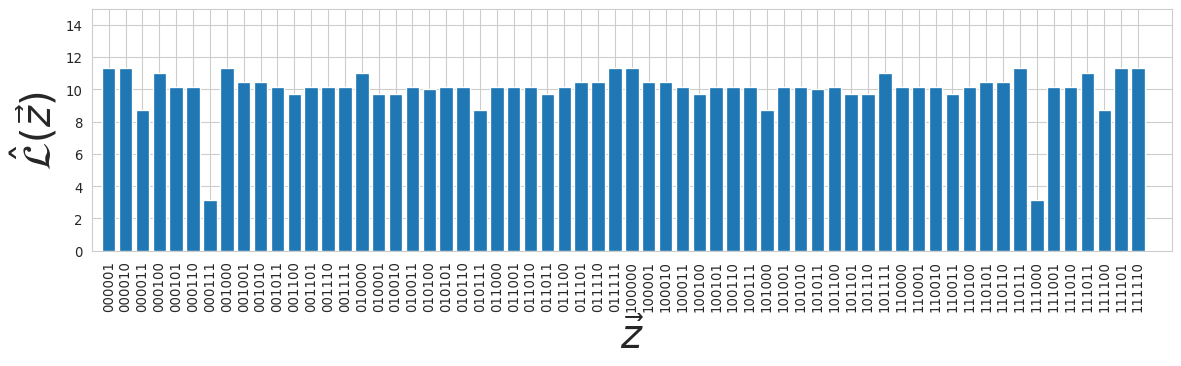

Min. Entropy block asssignment (a,b,c,d,e,f) = 000111


In [6]:
# Plot entropies for all possible block assignments
plt.clf()
plt.figure(figsize=(15,4), dpi=96)
plt.bar(range(1,(2**nodes)-1), entropies, align='center')
plt.xlim([0,2**nodes])
plt.ylim([0,15])
x_ticks = ["{0:b}".format(i).zfill(nodes) for i in range(1,(2**nodes)-1)]
plt.xticks(range(1,2**nodes-1), x_ticks)
plt.ylabel(r'$\hat{\mathcal{L}}(\vec{z})$', fontsize=30)
plt.xlabel(r'$\vec{z}$', fontsize=30)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(left=0.15)
plt.show()

# Find z that minimizes entropy
z_max = np.argmin(entropies)
z_max_vec = "{0:b}".format(1+z_max).zfill(nodes)
print("Min. Entropy block asssignment (a,b,c,d,e,f) =", z_max_vec)

We find that the minimal entropy is reached for the block assignment vectors that assign the "correct" communities:

In [7]:
SBM_min_entropy([0,0,0,1,1,1], n)

3.169925001442312

The entropy minimzation approach alone does not fix the issue with overfitting, since the ensemble where the block matrix corresponds to the adjacency matrix has zero entropy:

In [8]:
SBM_min_entropy([0,1,2,3,4,5], n)

0.0

To address this issue, we need to additionally incorporate the description length of the model, which we can calculate as follows according to lecture L05.

In [9]:
def Delta(z, network):
    B = len(set(z))
    m = network.M/2
    n = network.N
    x = (B*(B+1))/(2*m)
    return m * ((1+x) * np.log(1+x) - x * np.log(x)) + n * np.log(B)

The description length of the correct community assignment is as follows:

In [10]:
Delta([0,0,0,1,1,1], n)

10.267526103908605

The overfitted model has much larger description length:

In [11]:
Delta([0,1,2,3,4,5], n)

26.495940864694965

We can now compute the description length of the stochastic block model that includes both entropy and the model complexity as follows:

In [12]:
def description_length(z, network):
    return SBM_min_entropy(z, network) + Delta(z, network)

In [13]:
description_length([0,0,0,1,1,1], n)

13.437451105350917

In [14]:
description_length([0,1,2,3,4,5], n)

26.495940864694965

We can now reconsider the optimization approach that failed before (see exercise), i.e. we start by assigning each node to a separate block and then randomly merge communities:

In [16]:
def remap_communities(z):
    z_new = np.zeros(len(z), dtype=int)
    j = 0
    mapping = {}
    for i in range(len(z)):
        if z[i] not in mapping:
            mapping[z[i]] = j
            j += 1
    for i in range(len(z)):
        z_new[i] = mapping[z[i]]
    return z_new


def detect_communities_MDL(
        network: pp.Graph, 
        iterations = 1000, 
        cooling_slowness = 1,
        changes_per_iter = 1):
    # initialization
    z = np.array(np.arange(n.N))
    mdls = []
    for i in range(network.N):
        z[i] = i
    l = description_length(z, network)
    
    # we want to output the cooling temperatures to see the cooling schedule
    temperatures = []
    
    for i in tqdm(range(iterations)):
        # the temperature:
        t = (1+cooling_slowness)/(i+1+cooling_slowness)
        temperatures.append(t)
        
        # randomly split/merge communities
        if max(z)>0:
            i,j = np.random.choice(max(z)+1, replace=False, size=2)
            z_new = z.copy()
            z_new[z_new == i] = j
            z_new = remap_communities(z_new)
            l_new = description_length(z_new, network)
        else:
            x = np.random.choice(n.N, replace=False, size=int(n.N/2))
            z_new = z.copy()
            z_new[x] = 1
            z_new = remap_communities(z_new)

        if l_new <= l or np.random.random() <= np.exp(-(l_new-l)/t):
            z = z_new
            l = l_new
        mdls.append(l)
    return z, mdls, temperatures

In [17]:
z, l, t = detect_communities_MDL(n, iterations=100, cooling_slowness=10)

/tmp/ipykernel_97/3604363815.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
min_z = np.inf
min_l = np.inf
for i in range(10):
    z, l, t = detect_communities_MDL(n, iterations=100, cooling_slowness=10)
    x = description_length(z, n)
    if x < min_l:
        min_l = x
        min_z = z

/tmp/ipykernel_97/3604363815.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iterations)):


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
print(SBM_min_entropy(min_z, n))
print(Delta(min_z,n))
print(description_length(min_z, n))

colors = {0: 'red', 1: 'blue'}
pp.plot(n, node_color = [colors[min_z[n.mapping.to_idx(v)]] for v in n.nodes], node_label=[v for v in n.mapping.node_ids]);

3.169925001442312
10.267526103908605
13.437451105350917
